# Examples: Simple Snippets

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append("../")
from IoTPy.core.stream import Stream, StreamArray, run
from IoTPy.core.stream import _multivalue
from IoTPy.agent_types.basics import map_e
from IoTPy.helper_functions.recent_values import recent_values
from IoTPy.agent_types.op import map_element, map_window
from IoTPy.agent_types.basics import merge_e, map_w

# Illustrates decorator: @map_e

Define a function *f* which takes an input **x** and possibly additional keyword arguments and returns a single value. When you decorate *f* with @map_e, the function operates on an input stream with the additional keyword arguments, and outputs a stream in which the n-th element is *f* applied to the n-th element of the input stream.

# Example of @map_e

The n-th element of the output stream is a polynomial function of the n-th element of the input stream.

**evaluate_polynomial(number, polynomial)** has a parameter **number** which corresponds to an element of the input stream and a keyword argument **polynomial**. It returns a single value which is the element of the output stream.

In [2]:
"""
Agent that outputs polynomial of each element of the input stream.
"""
@map_e
def evaluate_polynomial(number, polynomial):
    return np.polyval(polynomial, number)


The decorated function **evaluate_polynomial** has an input stream, an output stream, and keyword arguments. '

In this example *y[n]*, the *n*-th element of the output stream **y** is the undecorated function **evaluate_polynomial** applied to *x[n]*, the *n*-th element of the iput stream **x**.

In [31]:
def test_evaluate_polynomial():
    """
    y[n] = f(x[n]) where f is the polynomial
    
    """
    # Declare streams
    x = StreamArray(name='x')
    y = StreamArray(name='y')

    # Create agent
    evaluate_polynomial(in_stream=x, out_stream=y, polynomial=[1, 0, 1])
    

    # Put data in input streams
    x.extend(np.array([1.0, 4.0, 3.0, 0.0]))

    # Execute a step
    print ('running')
    run()

    # Look at values of output streams
    assert np.array_equal(
        recent_values(y), np.array([2.0, 17.0, 10.0, 1.0]))
    print (recent_values(y))
    
test_evaluate_polynomial()

running
[ 2. 17. 10.  1.]


# Illustrates decorator: @merge_e for merging multiple input streams
## Magnitudes of vectors of inputs

Create agent that takes one input stream for each coordinate of 
a vector and outputs a stream which is the magnitude of the vector.

For example, if there are streams x, y, z where the coordinates of
the n-th point are x[n], y[n], z[n], then the n-th element of the
output stream is the magnitude of the vector [x[n], y[n], z[n]].

<h3>Step 1: Define Function</h3>
Define a terminating function, <i>magnitude_of_vector</i>, which takes an array of coordinates as its input and outputs the magnitude of a vector with these coordinates. For example magnitude_of_vector([3, 4]) = 5. The undecorated function has a single argument **coordinates** which is a list of coordinates of a vector, and it returns a single value which is the magnitude of the vector.

When it is decorated with @merge_e, the function has two arguments: a list of input streams corresponding to the coordinates and a single output stream of the magnitudes.

<h3>Step 2: Create Agent</h3>
   Decorate the function with <b>@merge_e</b> because we are creating an agent that merges multiple input streams into a single output stream.

In [4]:
@merge_e 
def magnitude_of_vector(coordinates):
    return np.linalg.norm(coordinates)

In [5]:
def test_magnitude_of_vector():
    """
    magnitude_stream[n] = magnitude_of([x[n], y[n], z[n]])

    """
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')
    z = StreamArray('z')
    magnitude_stream = StreamArray('magnitudes')

    # Create agent
    magnitude_of_vector([x,y,z], magnitude_stream)

    # Put data in streams
    x.extend(np.array([1.0, 4.0, 3.0]))
    y.extend(np.array([2.0, 4.0, 0.0]))
    z.extend(np.array([2.0, 2.0, 4.0]))

    # Execute a step
    run()

    # Look at values of output streams
    assert np.array_equal(recent_values(magnitude_stream),
                           np.array([3.0, 6.0, 5.0]))
    print (recent_values(magnitude_stream))
test_magnitude_of_vector()

[3. 6. 5.]


# Illustrates map_element with state and keyword argument

# Outputs are exponential smoothing of inputs

Function **f** has three arguments:
1. in_stream_element which is an element of the input stream
2. state which is the state of the agent. The initial value of state is specified in the call to f. Note that **state** is a keyword argument.
3. smoothing_factor which is a keyword argument.

In [33]:
def exponential_smoothing(in_stream, out_stream, smoothing_factor):
    """
    With input stream x and output stream y:
    y[0] = x[0]
    y[n] = a*x[n] + (1-a)*y[n-1] for n > 0.
    where a is smoothing_factor

    """
    def f(in_stream_element, state, a):
        if state == 'empty':
            next_state = in_stream_element
        else:
            next_state = (1.0-a)*state+ a*in_stream_element
            # return out_stream_element, next_state
            # Note: out_stream_element = next_state
            # So, return next_state, next_state
        return next_state, next_state
    # Create a map_element agent
    map_element(func=f, in_stream=in_stream, out_stream=out_stream,
                state='empty', a=smoothing_factor)

In [7]:
def test_exponential_smoothing():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    exponential_smoothing(in_stream=x, out_stream=y, smoothing_factor=0.25)

    # Put data in streams
    x.extend([1.0]+[0.0]*5)

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))

    x = StreamArray('x')
    y = StreamArray('y')

    exponential_smoothing(in_stream=x, out_stream=y, smoothing_factor=0.25)

    x.extend(np.arange(5.0))

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))
test_exponential_smoothing()

[1.         0.75       0.5625     0.421875   0.31640625 0.23730469]
[0.         0.25       0.6875     1.265625   1.94921875]


# Another example of exponential smoothing
# Example of map_element with state and keyword parameter

In [8]:
def exponential_smooth_and_add(in_stream, out_stream, smoothing_factor):
    """
    With input stream x and output stream y:
    y[n] = x[n] + a*x[n-1] + .. + a^m * x[n-m] + ....
    where a is smoothing_factor

    """
    def f(in_stream_element, state, a):
        next_state = state*a + in_stream_element
        # return out_stream_element, next_state
        # Note: out_stream_element = next_state
        return next_state, next_state
    # Create a map_element agent
    map_element(f, in_stream, out_stream,
                state=0.0, a=smoothing_factor)

In [9]:
def test_exponential_smooth_and_add():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    exponential_smooth_and_add(in_stream=x, out_stream=y, smoothing_factor=0.25)

    # Put data in streams
    x.extend([1.0]+[0.0]*5)

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))

    x = StreamArray('x')
    y = StreamArray('y')

    exponential_smooth_and_add(in_stream=x, out_stream=y, smoothing_factor=0.25)

    x.extend(np.arange(5.0))

    # Execute a step
    run()

    # Look at values of output streams
    #assert np.array_equal(recent_values(magnitude_stream), np.array([3.0, 6.0, 5.0]))
    print (recent_values(y))
test_exponential_smooth_and_add()

[1.000000e+00 2.500000e-01 6.250000e-02 1.562500e-02 3.906250e-03
 9.765625e-04]
[0.       1.       2.25     3.5625   4.890625]


# Illustrates map_window and StreamArray

## Outputs are a constant value aded to the inputs.

In [10]:
def add_value_to_stream_array(in_stream, out_stream, window_size, addend):
    """
    Each window is a NumPy array. Function f returns a numpy array of the same 
    size as the window. We need to put each element of the output numpy array as a 
    separate element of the output stream. So we use _multivalue which makes the 
    output stream a stream of numbers.
    
    If we didn't use _multivalue, the output stream would be a stream of numpy arrays
    each of which had a size equal to the window size.
    
    """
    def f(an_array):
        return _multivalue(an_array + addend)
    map_window(f,in_stream, out_stream,
        window_size=window_size,step_size=window_size)

In [11]:
def test_add_value_to_stream_array():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dtype='int')

    # Create agent
    add_value_to_stream_array(in_stream=x, out_stream=y, window_size=5, addend=10)
    
    # Put data in streams
    x.extend(np.arange(10))

    # Execute a step
    run()

    # Look at values of output streams
    print (recent_values(y))

test_add_value_to_stream_array()

[10 11 12 13 14 15 16 17 18 19]


# Illustrates map_window

## Outputs are dot products of constant vector and input windows.

In [12]:
def window_dot_product(in_stream, out_stream, multiplicand_vector, step_size=1):
    """
    f is a function that outputs the dot product of the multiplicand vector with
    a window of the input stream.
    
    The call to map_window makes out_stream a stream whose elements are f applied
    to moving windows.
    
    """
    def f(window, multiplicand_vector): return np.dot(window, multiplicand_vector)
    
    map_window(func=f, in_stream=in_stream, out_stream=out_stream,
               window_size=len(multiplicand_vector), step_size=step_size, 
               multiplicand_vector=multiplicand_vector)

In [13]:
def test_window_dot_product():
    # Declare streams
    x = StreamArray('x')
    y = StreamArray('y')

    # Create agent
    window_dot_product(in_stream=x, out_stream=y, multiplicand_vector=[2, 100])

    # Put data in streams
    x.extend(np.arange(8.0))

    # Execute a step
    run()

    # Look at values of output streams
    assert np.array_equal(recent_values(y), 
                          np.array([100., 202., 304., 406., 508., 610., 712.]))
    print (recent_values(y))

test_window_dot_product()

[100. 202. 304. 406. 508. 610. 712.]


# Illustrates decorator: @map_w for mapping windows.

## Output is the input with the input mean subtracted.

The undecorated function **subtract_mean** has a single argument **window** which is a list, and it returns the zero-th element minus the mean of the window.

The function, decorated with **map_w** takes a single input stream, and subtracts the mean of elements from sliding windows.

In [14]:

"""
Agent that subtracts the mean in a stream.
There are many ways of subtracting the mean of a stream.
This is the simplest though not the most efficient.
More efficient examples are given below.

"""
@map_w
def subtract_mean(window):
    return window[0] - np.mean(window)

## Example Plots
The next plot is of a sine wave with a mean of 1.0, and the following plot shows the result of applying subtract_mean() to that sine wave.
<br>
<br>
Note that the window size must be large compared to the wave length. For convenience, in these plots, the window size is a multiple of the wave length (measured in terms of number of points). In general, however, the window size should be much larger. 

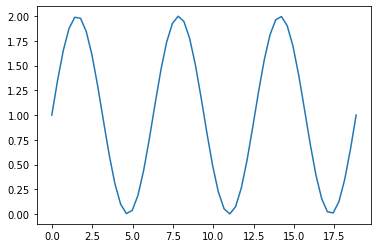

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
NUM_CYCLES= 3
NUM_POINTS_PER_CYCLE=18

x = np.linspace(0, NUM_CYCLES*2*np.pi, num=NUM_CYCLES*NUM_POINTS_PER_CYCLE)
y = np.sin(x) + 1.0

plt.plot(x, y)
plt.show()

# Apply sliding windows to subtract the mean

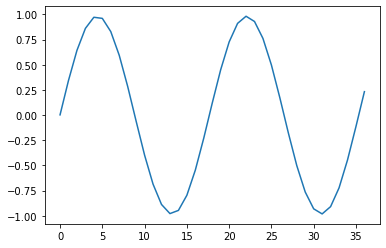

In [16]:
x = np.linspace(0, NUM_CYCLES*2*np.pi, num=NUM_CYCLES*NUM_POINTS_PER_CYCLE)
y = np.sin(x) + 1.0

y_stream = StreamArray('y_stream')
z = StreamArray('z')
subtract_mean(in_stream=y_stream, out_stream=z, window_size=18, step_size=1)
y_stream.extend(y)
run()
plt.plot(recent_values(z))
plt.show()

# Illustrates decorator: @map_w

## Efficient removal of mean from a stream using blocks.

In [17]:
"""
Agent that subtracts the mean of a stream in blocks.

The step size is made equal to the block size. The window size must be
many times the length of the longest wave of

Example: If the window size is 4 and the block size is 2, and 
the input stream is x and the output stream is y:
y[0, 1] consists of the first two elements of 
     x[0, 1, 2, 3] - np.mean(x[0, 1, 2, 3])
y[2, 3] consists of the first two elements of 
     x[2, 3, 4, 5] - np.mean(x[2, 3, 4, 5])

"""
@map_w
def subtract_mean_block(window, block_size):
    a = window - np.mean(window)
    return _multivalue(a[:block_size])

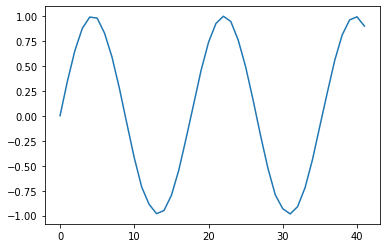

In [18]:
def test_subtract_mean_block():
    NUM_CYCLES= 3
    NUM_POINTS_PER_CYCLE=18

    # Data for streams.
    x = np.linspace(0, NUM_CYCLES*2*np.pi, num=NUM_CYCLES*NUM_POINTS_PER_CYCLE)
    y = np.sin(x) + 1.0
    # Declare streams
    y_stream = StreamArray('y_stream')
    z = StreamArray('z')
    subtract_mean_block(in_stream=y_stream, out_stream=z, window_size=18, step_size=6,
                       block_size=6)
    y_stream.extend(y)
    run()

    plt.plot(recent_values(z))
    plt.show()
test_subtract_mean_block()

# Illustrates decorator: @map_w

## Illustrates incremental computation on sliding windows

#### Outputs are sums of the values of sliding windows of the input.

In [19]:
def sum_window_incremental(in_stream, out_stream, window_size):
    """
    An agent that outputs the sum of all the elements in a window
    of the input stream. 
    out_stream[0] = in_stream[0]+in_stream[1]+...+in_stream[window_size-1]
    out_stream[m] = in_stream[m]+in_stream[m+1]+...+in_stream[window_size+m-1]
    The summation is carried out incrementally as a window moves.
    It adds the last element of the window and subtracts the element that
    drops out of the window at each step.

    The state is (starting, total) where starting is a Boolean and total
    is the sum of the last window excluding window[0].
    starting is True initially and becomes False after the sum of the first
    window is output.
    """
    @map_w
    def sum_window_incremental_func(window, state):
        starting, total = state
        if starting:
            starting = False
            total = sum(window)
        else:
            total += window[-1]
        next_state = starting, total-window[0]
        return total, next_state

    # Create agent
    sum_window_incremental_func(
        in_stream, out_stream, window_size, step_size=1, state=(True, 0))

In [20]:
def test_sum_window_incremental():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dtype='int')

    # Create agent
    sum_window_incremental(in_stream=x, out_stream=y, window_size=5)

    # Put data in streams
    x.extend(list(range(10)))

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_sum_window_incremental()

[10 15 20 25 30 35]


In [21]:
def subtract_mean_incremental(in_stream, out_stream, window_size):
    @map_w
    def subtract_mean_incremental_func(window, state):
        starting, total = state
        if starting:
            starting = False
            total = sum(window)
        else:
            total += window[-1]
        next_state = starting, total-window[0]
        mean_of_window = total/float(len(window))
        next_output = window[0] - mean_of_window
        return next_output, next_state

    # Create agent
    subtract_mean_incremental_func(
        in_stream, out_stream, window_size, step_size=1, state=(True, 0))

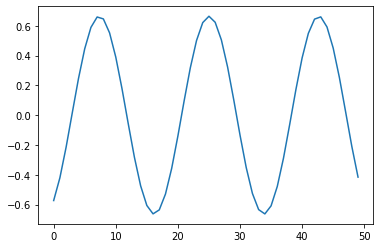

In [22]:
def test_subtract_mean_incremental():
    x_data = np.linspace(0, NUM_CYCLES*2*np.pi, num=NUM_CYCLES*NUM_POINTS_PER_CYCLE)
    y_data = np.sin(x) + 1.0
    
    # Declare streams
    y = StreamArray('y', dtype='float')
    z = StreamArray('z', dtype='float')

    # Create agent
    subtract_mean_incremental(in_stream=y, out_stream=z, window_size=5)

    # Put data in streams
    y.extend(y_data)

    # Execute a step
    run()

    plt.plot(recent_values(z))
    plt.show()

test_subtract_mean_incremental()

# Illustrates \_no\_value and @map_e

## Outputs are times at which the input crosses a threshold.

In [23]:
from IoTPy.core.stream import _no_value
"""
Agent outputs the time (indices) at which the absolute value of an element
of the input stream exceeds a threshold.
If the threshold is 2.5 and the input stream is
[1, 2, 5, 0, 9, 10, 11, 10, 9, 5, 1, 0, 2]
then the output stream is
[2 4 5 6 7 8 9] because 
in_stream[2] > threshold, in_stream[4] > threshold, ....

The state is the index of the next element of the input stream
that is read by the agent. Initially the state is 0. The state
is incremented by 1 at each step.

The output is the state if the threshold is exceeded and is
_no_value otherwise.
"""
@map_e
def time_of_crossing_threshold(value, state, threshold):
    return (state if abs(value) > threshold else _no_value, state+1)

In [24]:
def test_time_of_crossing_threshold():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dtype='int')

    # Create agent
    time_of_crossing_threshold(in_stream=x, out_stream=y, state=0, threshold=2.5)

    # Put data in streams
    x.extend([1, 2, 5, 0, 9, 10, 11, 10, 9, 5, 1, 0, 2])

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_time_of_crossing_threshold()

[2 4 5 6 7 8 9]


# Illustrates @map_e

## Quenching rate of alerts.

### Inputs are timed alerts and outputs are same as inputs with deletions of proximate alerts.


In [25]:
@map_e
def quenched_time_of_crossing_threshold(
        value, state, threshold, quench_duration):
    current_time, last_quench_time = state
    if ((current_time <= last_quench_time + quench_duration) or
        (abs(value) <= threshold)):
        signal = _no_value
    else:
        signal = (current_time, value)
        last_quench_time = current_time
    next_state = (current_time+1, last_quench_time)
    return signal, next_state

In [26]:
def test_quenched_time_of_crossing_threshold():
    # Declare streams
    x = StreamArray('x', dtype='int')
    y = StreamArray('y', dimension=(2,), dtype='int')

    # Create agent
    quenched_time_of_crossing_threshold(
        in_stream=x, out_stream=y, state=(0,0), threshold=2.5, quench_duration=2)

    # Put data in streams
    x.extend([1, 2, 5, 0, 9, 10, 11, 10, 9, 5, 1, 0, 2, 10, 10, 10, 10, 20, 1])

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_quenched_time_of_crossing_threshold()
    

[[ 4  9]
 [ 7 10]
 [13 10]
 [16 10]]


# Illustrates StreamArray & NumPy library

## Inputs are matrices and outputs are their inverses.

In [27]:
def test_invert_matrix():
    # Declare streams
    x = StreamArray(dimension=(2,2), dtype=float, name='x')
    y = StreamArray(dimension=(2, 2), dtype=float, name='y')

    # Create agent
    map_element(func=np.linalg.inv, in_stream=x, out_stream=y)

    # Put data in streams
    x.extend([np.array([[1.,2.],[3.,4.]]),
              np.array([[1.,0.],[0.,1.]])])

    # Execute a step
    run()

    # Look at values of output streams
    print(recent_values(y))

test_invert_matrix()

[[[-2.   1. ]
  [ 1.5 -0.5]]

 [[ 1.   0. ]
  [ 0.   1. ]]]


# Prime Number Sieve: Illustrates sink agent
A call to <i>sieve</i> creates a sink agent with an initial state of 0 and keyword parameters <i>prime_stream</i> and <i>out_stream</i>.
<br>
<b>prime_stream</b> is a stream of prime numbers.
<br>
The function <i>f</i> that is wrapped in <i>sink</i> does the following.
<ol>
    <li>For the first call, i.e., when <i>v</i> is the first element of the input stream, the state of the agent is set to this first element, and this value is appended to <i>prime_stream</i>, and then <i>f</i> calls <i>sieve</i> recursively with an empty <i>out_stream</i>.</li>
    <li>For subsequent calls, the element <i>v</i> of the input stream is appended to <i>out_stream</i> if it is not a multiple of <i>state</i>. </li>
    </ol>

In [28]:
from IoTPy.agent_types.sink import sink
def sieve(in_stream, prime_stream):
    def f(v, state, prime_stream, out_stream):
        if state == 0:
            prime_stream.append(v)
            state = v
            sieve(out_stream, prime_stream)
        else:
            if v % state != 0: 
                out_stream.append(v)
        return state
    sink(func=f, in_stream=in_stream, state=0,
         prime_stream=prime_stream, out_stream=Stream())

In [29]:
def test_sieve():
    x = Stream('x')
    y = Stream('y')
    sieve(x, y)
    x.extend(list(range(2, 20)))
    run()
    assert recent_values(y) == [2, 3, 5, 7, 11, 13, 17, 19]

In [30]:
def sieve_N(N, step_size):
    x = Stream('x')
    y = Stream('y')
    sieve(x, y)
    n = 2
    finished = False
    while not finished:
        x.extend(list(range(n, n+step_size)))
        n += step_size
        run()
        finished = (len(recent_values(y)) >= N)
    return recent_values(y)[:N]
# Sieve for N primes
print (sieve_N(10, 5))

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]
